In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from IPython.display import display

In [3]:
# astropy is part of sciserver's essentials 2.0
# pip install photutils

In [3]:
# https://photutils.readthedocs.io/en/stable/detection.html
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

In [4]:
class sky(object):
    
    def __init__(self, seed=42, arcsec=100, objects=2, factor=1):
        "simulate objects"
        self.rng = np.random.default_rng(seed=seed)
        self.arcsec = arcsec
        obj_ = self.rng.random(size=(objects, 3))
        obj_[:,:2] *= arcsec * factor # compress
        obj_[:,:2] += arcsec * (1-factor)/2 #shift
        if False:
            # brightness from 0.5 to 1
            obj_[:,2] += 1 
            obj_[:,2] *= 0.5
        self.truth = pd.DataFrame(obj_, columns=["x", "y", "u"])
    
    def photons(self, psf_arcsec=0.65, exptime=100):
        "fig 1 of https://arxiv.org/pdf/0805.2366.pdf"
        for it,row in self.truth.iterrows():
            yield self.rng.normal(loc=[row.x,row.y], scale=psf_arcsec/2, size=(int(row.u*exptime),2))

            
class observe(object):
    
    def __init__(self, patch, pixel_arcsec=0.2):
        self.patch = patch
        self.pixel_arcsec = pixel_arcsec
        
    def image(self, psf=0.65, exptime=10000, bg=0):
        "simulate an image"
        pix = 1+int(np.ceil(self.patch.arcsec / self.pixel_arcsec))
        img = np.zeros((pix,pix), dtype=np.float64)
        for it,arcsec in enumerate(self.patch.photons(psf, exptime)):
            t = np.floor(arcsec / self.pixel_arcsec).astype(int)
            for i,j in t:
                img[j,i]+=1
        if bg:
            img += self.patch.rng.poisson(bg * exptime, img.shape)
        return img
    
    @staticmethod
    def daofind(data, fwhm=4, threshold=5, sigma_clip=3):
        "source detection, see at https://photutils.readthedocs.io/en/stable/detection.html"
        mean, median, std = sigma_clipped_stats(data, sigma=sigma_clip) 
        daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*std)  
        return daofind(data - median)  

In [5]:
# simulate a patch of sky
patch = sky(seed=99, arcsec=5, objects=2, factor=0.3)
obs = observe(patch)

# show the truth
display(patch.truth[['x','y']] / obs.pixel_arcsec)

# create catalogs with random PSFs
cat = dict()
for it,psf in enumerate(patch.rng.normal(0.65, 0.15, 5)):
    img = obs.image(psf=psf, exptime=100000, bg=0.5)
    src = observe.daofind(img, fwhm=psf/obs.pixel_arcsec, threshold=5, sigma_clip=3)
    if src: src['psf'] = psf * np.ones_like(src['xcentroid'])
    cat[it] = img, src # save results
    display(src[['id','xcentroid','ycentroid','psf']])

,x,y
0,12.545230,12.988187
1,16.041398,13.361774


id,xcentroid,ycentroid,psf
int64,float64,float64,float64
1,12.876869958458526,12.513129571662372,0.5813235741104343
2,14.76865914206337,12.952583231560965,0.5813235741104343


id,xcentroid,ycentroid,psf
int64,float64,float64,float64
1,12.782119787317999,12.652153340469075,0.5605369858091679
2,14.79923100673773,12.741879904264543,0.5605369858091679


id,xcentroid,ycentroid,psf
int64,float64,float64,float64
1,12.548339428047724,12.596491874448137,0.49295486565763613
2,15.214863879875384,12.866093052219032,0.49295486565763613


id,xcentroid,ycentroid,psf
int64,float64,float64,float64
1,13.908071097541253,12.769837417194719,0.7897688034192194


id,xcentroid,ycentroid,psf
int64,float64,float64,float64
1,13.975809378449233,12.677033004465546,0.7512470725369408


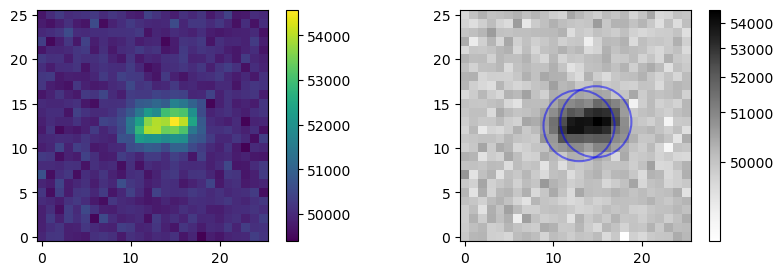

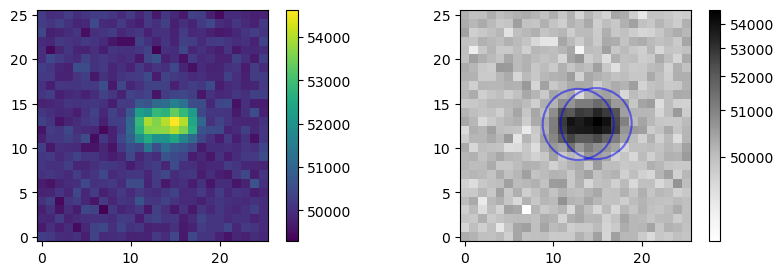

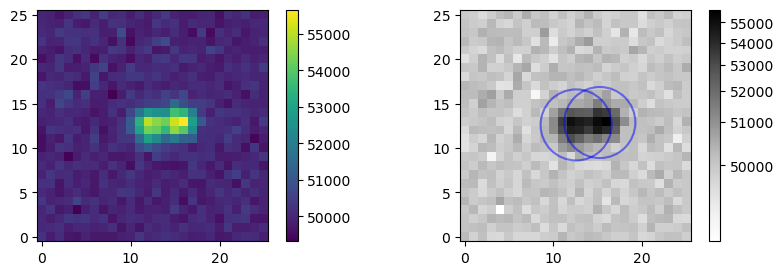

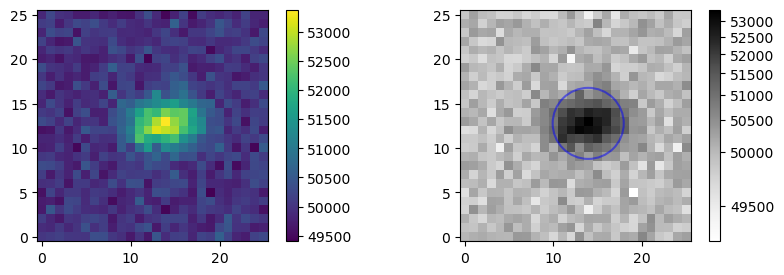

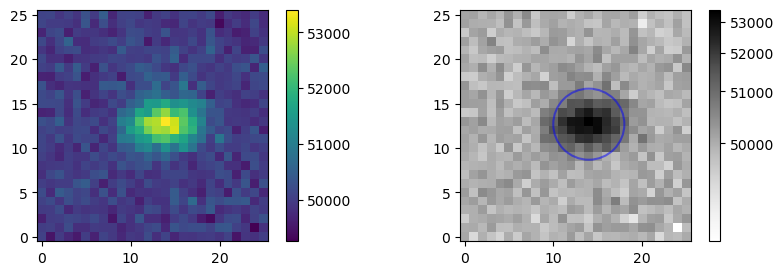

In [7]:
for k in cat:
    img, src = cat[k]
    #display(src) #[['id','xcentroid','ycentroid','psf']])
    plt.figure(figsize=(10,3)); plt.subplot(1,2,1)
    plt.imshow(img, interpolation='nearest', aspect='equal', origin='lower'); plt.colorbar();    
    positions = np.transpose((src['xcentroid'], src['ycentroid']))
    plt.subplot(1,2,2)
    plt.imshow(img, cmap='Greys', origin='lower', norm=ImageNormalize(stretch=SqrtStretch()), interpolation='nearest')
    apertures = CircularAperture(positions, r=4.)
    apertures.plot(color='blue', lw=1.5, alpha=0.5); plt.colorbar();